# [AHA! Activity Health Analytics](http://casas.wsu.edu/)
[Center for Advanced Studies of Adaptive Systems (CASAS)](http://casas.wsu.edu/)

[Washington State University](https://wsu.edu)

# L3-2 Activity Density Maps

## Learner Objectives
At the conclusion of this lesson, participants should have an understanding of:
* Creating activity density maps
* Working with major and minor tick formatters

## Acknowledgments
Content used in this lesson is based upon information in the following sources:
* [Wang et al., 2012](http://ieeexplore.ieee.org/document/6189784/?section=abstract)

## Activity Density Maps
An Activity Density Map (ADM) is a heat map proposed by [Wang et al., 2012](http://ieeexplore.ieee.org/document/6189784/?section=abstract) to visualize daily activity as a function of 24 hour time (Y-axis) and window time (X-axis). From Wang and colleague's original paper: 
> In the density map, different colors are used to represent different levels of motion sensor density. The density is computed
as the number of all motion sensor hits during 1 h divided by time at home during that hour. Examples of density maps are shown in [the figure below]. The X-axis represents days in a month. The Y-axis represents hours in a day, from midnight (top) to 11 PM
(bottom). The colorbar on the right of the figure shows the colors by density range. Black represents TAFH (time away from home). White corresponds to very low density. Colors change from light gray (at the low end of 50 events/h), yellow, green, light blue to dark blue at the high end (550 events/h or more). In the density map, the density is calculated for each hour block; TAFH is computed to the second.

Here are two examples of ADMs from the original paper (on the left is an ADM for someone who lives an active lifestyle. On the right is an ADM from someone who lives a sedentary lifestyle):
<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/ADM_wang.bmp" width="600">

We are going to adopt Wang and colleague's ADM to visualize longitudinal Fitbit data. We can create ADMs for any of the minute by minute Fitbit metrics, such as steps, heart rate, floors climbed, etc. Such ADMs will be useful for quickly seeing patterns at different time granularities. Here is the end goal of what our Matplotlib-created Fitbit ADMs will look like:
<img src="https://raw.githubusercontent.com/gsprint23/aha/master/lessons/figures/ADM_example.png" width="700">

## Fitbit Data
We will work with 15 days of example Fitbit data available in [fitbit_example_data.zip](https://raw.githubusercontent.com/gsprint23/aha/master/lessons/files/fitbit_example_data.zip). The format of this data is the same as the Fitbit data frame we wrote to a csv file in the previous lesson. Since we have one csv file per day, we will read in each csv file as a data frame with a `DateTimeIndex` representing each minute in the day. We will save the data frames in an ordered dictionary of date (string) to fitbit data (data frame) pairs.

In [50]:
from collections import OrderedDict
import os
import pandas as pd

data_dir = r"files\fitbit_example_data"        
intraday_files = OrderedDict()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for fil in filenames:
        parts = fil.split("_")
        day = parts[1][:10]
        relative_path = data_dir + "\\" + fil
        df = pd.read_csv(relative_path, header=0, parse_dates={"time": [0]})
        df.set_index("time", inplace=True)
        intraday_files[day] = df

Now that we have read all of the data in, we will next extract a metric and build a data frame containing only data for that metric. For the rest of the example, let's work exclusively with Fitbit steps. Accordingly, we will extract the "steps" column from each day's data frame. We will construct a new data frame with the same minute by minute index, but with step columns labeled for each day.

In [51]:
day1 = list(intraday_files.keys())[0]
# be aware that this removes a key-value pair from the dictionary each time it executes
day1_df = intraday_files.pop(day1)
day1_steps_ser = day1_df["steps"]
day1_steps_ser.name = day1 # instead of "steps"
steps_df = pd.DataFrame(day1_steps_ser)
for day, df in intraday_files.items():
    steps_df[day] = df["steps"]
print(steps_df.head())
# write steps_df out to file for later use
steps_df.to_csv(data_dir + "_steps_df.csv")

                     2015-10-01  2015-10-02  2015-10-03  2015-10-04  \
time                                                                  
2017-05-31 00:00:00         0.0         0.0         0.0         0.0   
2017-05-31 00:01:00         0.0         0.0         0.0        14.0   
2017-05-31 00:02:00         0.0         0.0         0.0        60.0   
2017-05-31 00:03:00         0.0         0.0         4.0        10.0   
2017-05-31 00:04:00         0.0         0.0         7.0         8.0   

                     2015-10-05  2015-10-06  2015-10-07  2015-10-08  \
time                                                                  
2017-05-31 00:00:00         0.0        49.0         0.0         5.0   
2017-05-31 00:01:00         0.0         0.0         0.0        26.0   
2017-05-31 00:02:00         0.0         0.0         0.0        17.0   
2017-05-31 00:03:00         0.0         5.0         0.0        53.0   
2017-05-31 00:04:00         0.0        29.0         0.0        45.0   

    

## Constructing an ADM
### Part 1: Initial Plot
To make an ADM of the steps data frame, we will create a heat map with a color bar.

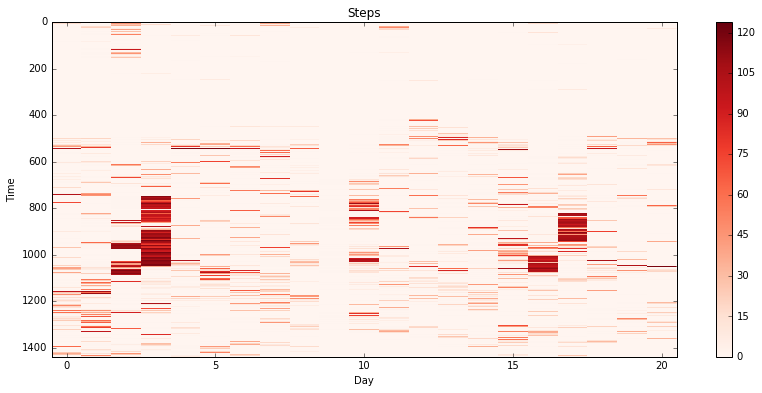

(<matplotlib.figure.Figure at 0xf6dbaa52e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0xf6e12edf60>)

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import numpy as np
import datetime

def adm(data_df, title_label, show=True):
    '''
    
    '''
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("Reds")
    im = plt.imshow(data_df, interpolation='none', aspect='auto', cmap=cmap)
    plt.colorbar(im)
    plt.xlabel("Day")
    plt.ylabel("Time")
    plt.title(title_label)
    fig.set_size_inches(14, 6)
    if show:
        plt.show()
    return fig, ax # for adding labels and grid lines later
    
adm(steps_df, "Steps")    

Cool! It only took a few lines of code to build a rudimentary ADM. There are few things missing on this ADM though that would be quite nice to have:
1. X axis labels for each *date* instead of the day number in the sequence. This will help give context for the data (e.g. what season? are the days contiguous?).
    1. X axis labels for each *day of the week* in addition to the date. This will provide even more context for the data (e.g. a weekday vs. a weekend?).
    1. Vertical grid lines to divide the heat map according to the date labels.
1. Y axis labels for each *hour of the day* instead of the minute number in the index. This will help ADM readers quickly see where key hours of the day are, like noon or what time the Fitbit wearer wakes up.
    1. Horizontal grid lines to divide the heat map according to the hour labels.

### Part 2: Beautifying the Plot
Let's beautify our ADM by addressing the changes listed above. First, let's work on adding labels and grid lines to the X-axis.

Note: the following code works with [Matplotlib tickers](https://matplotlib.org/api/ticker_api.html) for tick location and formatting. To learn more about tickers, see the [Matplotlib website](https://matplotlib.org/api/ticker_api.html).

In [53]:
def get_days_of_week(date_arr):
    '''
    get the day of week string from the Python datetime module
    https://docs.python.org/3/library/datetime.html#datetime.date.weekday
    '''
    days_of_week = []
    for d in date_arr:
        weekday = datetime.datetime.strptime(str(d)[:10], "%Y-%m-%d").date().strftime("%A")
        days_of_week.append(weekday[:2])
    return days_of_week

def setup_xaxis(data_df, ax):
    '''
    set x axis labels for each date
    '''
    date_labels = data_df.columns
    num_days = len(date_labels)
    
    # major ticks are for date labels
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(num_days)))
    ax.set_xticklabels(date_labels, rotation=90, ha='center')
    # no need to display major ticks, they are just for positioning the labels
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
        
    # minor ticks are for vertical grid lines to separate days
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(-0.5, num_days, 1)))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.grid(True, which='minor', color='black', linestyle='-')
    
def setup_top_xaxis(data_df, fig, ax):
    '''
    set day of week (e.g. monday, tuesday, etc.) labels on the top of the plot
    '''
    num_days = len(data_df.columns)
    days_of_week = get_days_of_week(data_df.columns)
    
    # add another axes to the plot that will have different x labels from the "master" axes
    ax2 = fig.add_axes(ax.get_position(), frameon=False)
    # only want top labels on
    ax2.tick_params(labeltop="on", labelbottom="off", labelleft="off", left="off", right="off")
    # set the x limits and major ticks to be the same as the "master" axes
    ax2.set_xlim(ax.get_xlim())
    ax2.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, num_days, 1)))
    # set different major tick labels. use day of the week labels
    ax2.set_xticklabels(days_of_week)
    # no need to display major ticks, they are just for positioning the labels
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

And now, let's work on adding labels and grid lines to the Y-axis.

In [54]:
def setup_yaxis(data_df, ax):
    '''
    set y axis labels for each hour
    '''
    num_indices = len(data_df.index)
    hour_labels = [t.strftime("%I %p") for t in pd.date_range("00:00", "23:00", freq="60T")]

    # major ticks are for hour labels
    ax.yaxis.set_major_locator(ticker.FixedLocator
        (np.arange(-0.5 + num_indices / 24.0 / 2.0, num_indices, num_indices / 24.0)))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(hour_labels))
    # no need to display major ticks, they are just for positioning the labels
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    
    # minor ticks are for horizontal grid lines to separate hours
    ax.yaxis.set_minor_locator(ticker.FixedLocator
       (np.arange(-0.5, num_indices + num_indices / 24.0 / 2.0, num_indices / 24.0)))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    # add hour labels to the right side of the plot as well
    ax.yaxis.set_tick_params(labelright='on')
    ax.yaxis.grid(True, which='minor', color='black', linestyle='-')

We are ready to test it out!

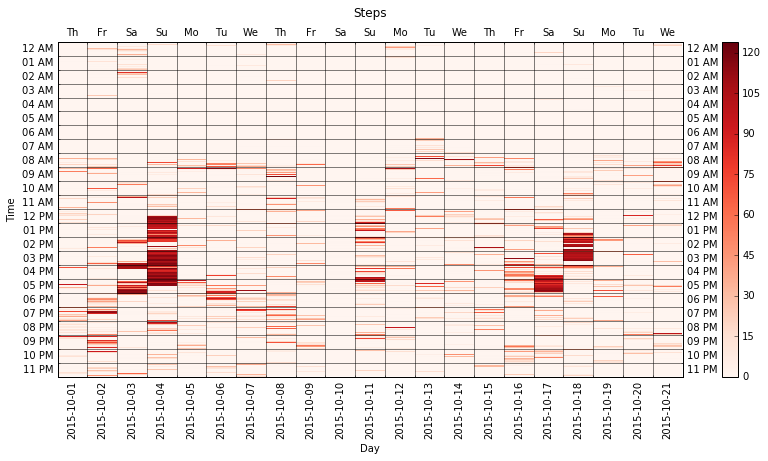

In [55]:
def adm_beautified(data_df, title_label):
    '''
    
    '''
    fig, ax = adm(data_df, title_label, False)
    # move the title up to make room for the day of the week labels
    plt.title(title_label, y=1.06)
    setup_xaxis(data_df, ax)
    setup_top_xaxis(data_df, fig, ax)
    setup_yaxis(data_df, ax)
    plt.show()
    
adm_beautified(steps_df, "Steps")  

## Aggregated ADMs
Using [`resample()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), we can aggregate our time series to different time periods and visualize the aggregation using an ADM.

### Example: 15 Minutes

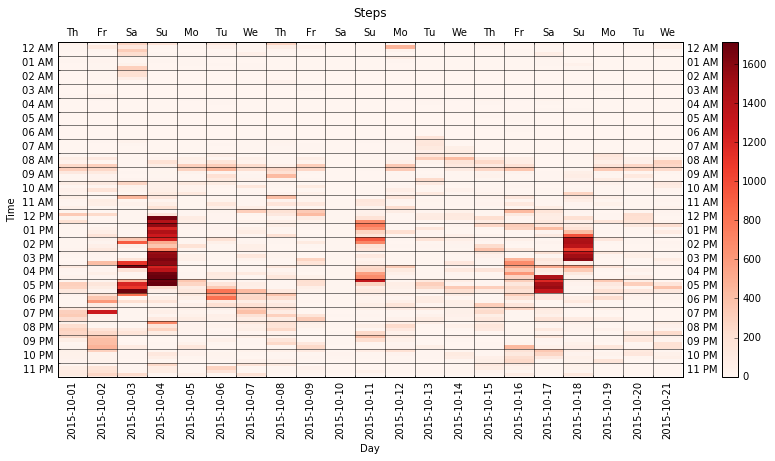

In [56]:
mins15_steps_df = steps_df.resample("15T").sum()
adm_beautified(mins15_steps_df, "Steps")

### Example: Hourly

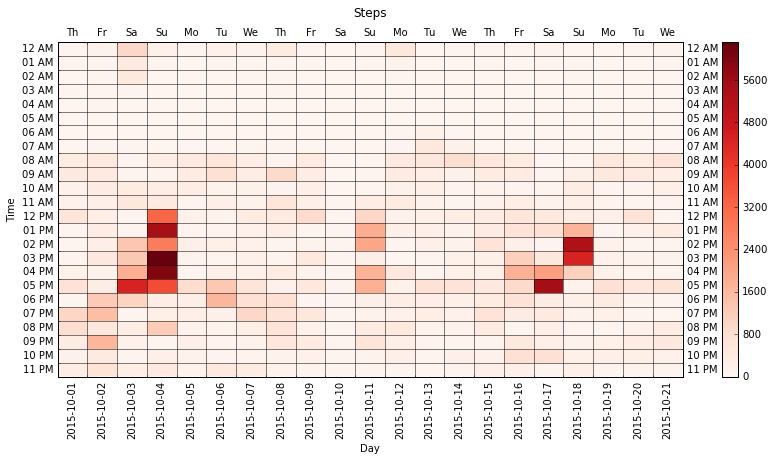

In [57]:
hourly_steps_df = steps_df.resample("1H").sum()
adm_beautified(hourly_steps_df, "Steps")